In [1]:
%%html
<style>body{--vscode-font-family: "D2Coding"}</style>

In [2]:
%matplotlib inline 
import numpy as np
from scipy.optimize import fsolve, newton
from scipy.special import jv, kv, jn_zeros
import matplotlib.pyplot as plt

## Graphical Method

LP모드의 특성방정식은 graphical methods로 검토하고 수치적(numerically)로 풀어야한다.   
그래프를 검토할 때 특성방정식의 좌변과 우변을 잘 설정하면 솔루션의 특징을 유추하는데 많은 도움이된다.  
특히 좌변을 아래와 같이 잡으면,  
$$
u \frac{J_{l-1}(u)}{J_{l}(u)}
$$
베셀방정식 $J_{l}(u)$ 값이 0이 되는 포인트마다 발산하는 경계가 생겨 분석에 기준을 제공한다.

좌변의 정의에 따라 우변은 다음과 같이 정리된다.
$$
-w \frac{K_{l-1}(w)}{K_{l}(w)}
$$

아래 위 수식을 표현하는 함수를 정의했다.

In [3]:
def eigeq_left(V, l):
    def lhs(u):
        w = np.sqrt(V*V - u*u)
        return u*jv(l-1, u) / jv(l, u)
    return lhs

In [4]:
def eigeq_right(V, l):
    def rhs(u):
        w = np.sqrt(V*V - u*u)
        return -w*kv(l - 1, w) / kv(l, w)
    return rhs

분석의 편의를 위해 베셀함수 $J_{l-1}(u)$ 혹은, $J_{l}(u)$가 0이 되는 u 값을 알 필요가 있다.  
특히, 다양한 V 값에 대해 솔루션을 찾고 그래프에 점근선을 나타내기 위해서는 $u = [0, V]$ 일때,  
$J_{l}(u) = 0$(분모가 0)이 되는 모든 u 값의 리스트를 알면 좋다.  
다음과 같이 `find_max_num_jn_zeros(l, V)`를 정의해 V 보다 작은 최대 u 값이 몇번째 0를 만드는지 알아낸 후,  
이 값을 `scipy.special`의 함수 `jn_zeros()`에 넣어 $J_{l}(u) = 0$를 만드는 u 값의 시퀀스를 얻을 수 있다.    

In [5]:
# example for the fixed V and l
V = 9
l = 0
def find_max_num_jn_zeors(l, V):
    start = 1
    while jn_zeros(l, start)[-1] < V:
        start += 1
    max_num = start
    return max_num - 1

max_num = find_max_num_jn_zeors(l, V)
print(jn_zeros(l, max_num))

[2.40482556 5.52007811 8.65372791]


이는 특성방정식 좌변의 함수 $u \frac{J_{l-1}(u)}{J_{l}(u)}$가 발산하는 점근선의 위치를 말해준다.
다음을 확인하자. 

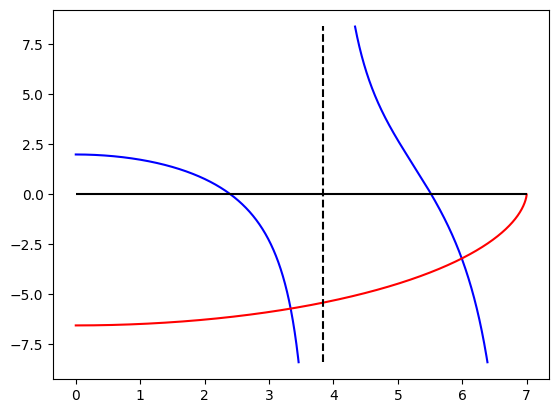

In [6]:
def plot_left_right_eq(V, l):
    u = np.linspace(0.00001, V-0.00001, int(V*1000))
    lhs = eigeq_left(V, l)
    lhs = lhs(u)
    rhs = eigeq_right(V, l)
    rhs = rhs(u)

    # Limits plot range by setting values over 1.2V as 'None'
    plot_limit = 1.2*V
    mlhs = np.where(abs(lhs) >= plot_limit, None, lhs)
    mrhs = np.where(abs(rhs) >= plot_limit, None, rhs)

    plt.plot(u, mlhs, color='blue') # plot left-side of eigen-value eq.
    plt.plot(u, mrhs, color='red')  # plot right-side of eigen-value eq.
    plt.hlines(y=0, xmin=0, xmax=V, colors='k') # plot x axis.

    # plot diverging assymtotic lines
    max_num = find_max_num_jn_zeors(l, V)
    aymtotic_vertical_lines = jn_zeros(l, max_num) 
    for n in aymtotic_vertical_lines:
        plt.vlines(x=n, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k')

plot_left_right_eq(V=7, l=1)

위에서 파란색 그래프(left-side equation)와 빨간색그래프(right-side equation)가 만나는 점에서의 x축 값이 LPlm 모드의 u값이 된다. 이 u 값을 구하는 것이 LP 모드를 기술하는 핵심 목표가 된다. 이 값으로부터 LP 모드의 field를 구할 수 있으며, 광섬유 파라미터와 함께 유효굴절률 계산도 가능해진다. 

## Getting `u` value
LHS-RHS = 0 형태, 즉
$$
u \frac{J_{l-1}(u)}{J_{l}(u)} + w \frac{K_{l-1}(w)}{K_{l}(w)} = 0
$$
의 u에 대한 수치해를 구해야한다. 
`scipy` 모듈의 `fsolve()` 함수를 사용해 쉽게 구할 수 있는데 이때 수치해 계산을 시작하는 시작점(initial value)을 잘 정의해 주어야 수렴하는 해를 얻을 수 있다.  
이때 위 그래프에서 점근선이 중요한 기준 역할을 한다. 

C:\Users\jkkow\AppData\Local\Temp\ipykernel_9056\985792259.py:9: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(V*V - u*u)


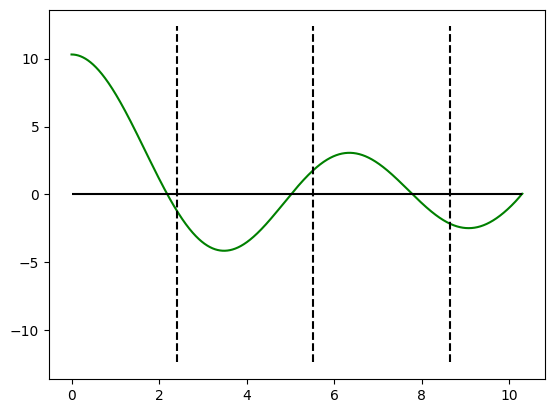

In [7]:
def eigeq_LP_lm(V, l):
    def to_cal(u):
        w = np.sqrt(V*V - u*u)
        return u * jv(l - 1, u) / jv(l, u) + w * kv(l - 1, w) / kv(l, w)
    return to_cal

def eigeq2_LP_lm(V, l):
    def to_cal(u):
        w = np.sqrt(V*V - u*u)
        return u * jv(l - 1, u) * kv(l, w) / kv(l - 1, w) + w * jv(l, u) 
    return to_cal

def plot_eigen_eq(V, l):

    u = np.linspace(0.000001, V-0.0001, int(V*1000)) # u=0 diverges. So have to be avoided.
    plot_limit = 1.2*V
    func_to_cal = eigeq_LP_lm(V, l)(u)
    mfunc_to_cal = np.where(abs(func_to_cal) >= plot_limit, None, func_to_cal)

    plt.plot(u, mfunc_to_cal, color='green')
    plt.hlines(y=0, xmin=0, xmax=V, colors='k')

    max_num = find_max_num_jn_zeors(l, V)
    aymtotic_vertical_lines = jn_zeros(l, max_num)
    for n in aymtotic_vertical_lines:
        plt.vlines(x=n, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k')

def plot_eigen_eq2(V, l):

    u = np.linspace(0.000001, 2*V, int(V*1000))
    plot_limit = 1.2*V
    func_to_cal = eigeq2_LP_lm(V, l)(u)
    mfunc_to_cal = np.where(abs(func_to_cal) >= plot_limit, None, func_to_cal)

    plt.plot(u, mfunc_to_cal, color='green')
    plt.hlines(y=0, xmin=0, xmax=V, colors='k')

    max_num = find_max_num_jn_zeors(l, V)
    aymtotic_vertical_lines = jn_zeros(l, max_num)
    for n in aymtotic_vertical_lines:
        plt.vlines(x=n, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k')

# plot_eigen_eq(V=10.3, l=0)
plot_eigen_eq2(V=10.3, l=0)

### Setting initial values to find root

다양한 $V$와 $l$ 값에 대해 특성방정식이 어떤 형태를 보이는지 살펴보고 수치해를 찾기 위해 초기값을 어떻게 설정할지 판단하자.  

Assymtotic vertical lines at [3.83170597]
Init values: [3.33170597]
root: [3.15272537]
End value of left-side equation: 2.7107460600226814


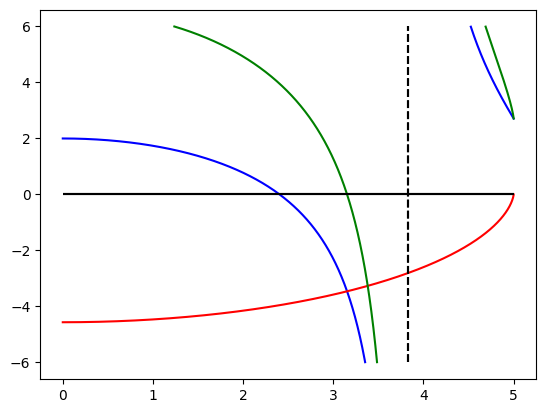

In [8]:
V = 5
l = 1

# plot to analyze
plot_left_right_eq(V,l)
plot_eigen_eq(V, l)

max_num = find_max_num_jn_zeors(l, V)
asymtotic_vertical_lines = jn_zeros(l, max_num)
print(f"Assymtotic vertical lines at {asymtotic_vertical_lines}")


# set initial values to find root of eigen-value eq.
init_values = asymtotic_vertical_lines - 0.5
print(f"Init values: {init_values}")
roots = fsolve(eigeq_LP_lm(V,l), init_values)
print(f"root: {roots}")

left_eq_of_right_end = eigeq_left(V,l)(V)
print(f"End value of left-side equation: {left_eq_of_right_end}")

if left_eq_of_right_end < 0:
    add_init = V - 0.00001
    root = fsolve(eigeq_LP_lm(V, l), add_init)
    print(f"additional init point at {add_init}")
    print(f"additional root at {root}")

## Cutoff Value

cutoff value는 $w=0$ 일 때 특성방정식의 해를 구하면 알 수 있다. 즉 'left-side eq.'가 0이 되는 u값(Vc)을 말하는 것으로 


In [9]:
jn_zeros(2, 1)

array([5.1356223])